# Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
# Get information from last interactive cell
out_len=len(Out)
for index,n in enumerate(Out):
    if index==out_len-1:   _=Out[n]
    if index==out_len-2:  __=Out[n]
    if index==out_len-3: ___=Out[n]
    if index==out_len-4:____=Out[n]

<font color='deepskyblue'>**1.**</font> 
<br>a. Now, I read in the `ab_data.csv` data, store it in `df` and take a look at the top 10 rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. The number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.query('converted == "1"').count().converted/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
wrong_treat = df.query('group == "treatment" & landing_page == "old_page"').count()[0]
wrong_cont = df.query('group == "control" & landing_page == "new_page"').count()[0]

print('Wrong treatment:',format(wrong_treat),
     '\nWrong control:  ',format(wrong_cont),
     '\nTotal:          ',format(wrong_treat+wrong_cont))

Wrong treatment: 1965 
Wrong control:   1928 
Total:           3893


f. The number of missing values in each row.

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

<font color='deepskyblue'>**2.**</font>
<br>a. I now create a new dataset, `df2`. And drop the rows where `treatment` is not aligned with `new_page` and `control` is not aligned with `old_page`, as we cannot be sure if this row truly received the new or old page.

In [9]:
df2 = df.copy()
df2.shape[0]

294478

In [10]:
#Drop rows that do not align with each other
df2.drop(df.query('group == "treatment" & landing_page == "old_page"').index,inplace=True)
df2.drop(df.query('group == "control" & landing_page == "new_page"').index,inplace=True)

In [11]:
# Double Check all of the incorrect rows were removed - this should be 0
(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0], 
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0])

(0, 0)

In [12]:
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


<font color='deepskyblue'>**3.**</font>
<br>a. Number of unique `user_id`s in `df2`.

In [13]:
df2.nunique().user_id

290584

b. Show the repeated `user_id`s in `df2` and print the row information for the repeat `user_id`.

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. Remove one of the duplicate `user_id` row, but keep your dataframe as `df2`.

In [15]:
df2.drop([2893], axis=0, inplace=True)
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


<font color='deepskyblue'>**4.**</font> 
<br>a.  The probability of an individual converting regardless of the page they receive.

In [16]:
df2.converted.mean()

0.11959708724499628

b. The probability an individual converted given that they were in the `control` group.

$P(Converted|Control)= P(\frac{\text{Converted ∩ Control}}{\text{Control}})$

In [17]:
pcc = df2.query('group == "control" & converted == "1"').count().converted/df2.query('group == "control"').count().converted
pcc

0.1203863045004612

c. The probability an individual converted given that they were in the `treatment` group.

$P(Converted|Treatment)= P(\frac{\text{Converted ∩ Treatment}}{\text{Treatment}})$

In [18]:
pct = df2.query('group == "treatment" & converted == "1"').count().converted/df2.query('group == "treatment"').count().converted
pct

0.11880806551510564

d. What is the probability that an individual received the new page?

$P(new\_page)$

In [19]:
df2.query('landing_page == "new_page"').count().landing_page/df2.shape[0]

0.5000619442226688

e.

In summary:
- there is a 11.96% chance that an individual converted regardless of the page they receive
- there is a 12.04% chance that an individual converted given that they were in the control group.
- there is a 11.88% chance that an individual converted given that they were in the treatment group.
- there is a 50% chance that an individual received the new page

I think that there is insufficient evidence to say that the new treatment page leads to more conversions. Both control and treatment pages have similar conversions rates, and because they do not range significantly, we cannot draw the conclusion that one page is better than another.


<a id='ab_test'></a>
### Part II - A/B Test

<font color='deepskyblue'>**1.**</font>  
I am going to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. **$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages. My null and alternative hypotheses be are:

$p_{old} : \text{old - new} \geq 0$

$p_{new} : \text{old - new < 0}$

<font color='deepskyblue'>**2.**</font>  
I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the `converted` success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I assume they are equal to the `converted` rate in `ab_data.csv` regardless of the page. <br>

I am going to use a sample size for each page equal to the ones in `ab_data.csv`.  <br>

I will then perform the sampling distribution for the difference in `converted` between the two pages over 10,000 iterations of calculating an estimate from the null.  <br>

a. The **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. Value of $n_{new}$,  the number of individuals in the treatment group

In [22]:
n_new = df2.query('group == "treatment"').count().group
n_new

145310

d. Value of $n_{old}$,  the number of individuals in the control group

In [23]:
n_old = df2.query('group == "control"').count().group
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in `new_page_converted`.

In [24]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11931043974950106

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in `old_page_converted`.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11914726654459848

g. $p_{new}$ - $p_{old}$ for my simulated values from parts (e) and (f).

In [26]:
sim_diffs = new_page_converted.mean() - old_page_converted.mean()
sim_diffs

0.00016317320490258358

h. Next, I do 10,000 simulations of $p_{new}$ - $p_{old}$ values using this same process detailed from a. to g. above and store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# Simulation for converted new and old pages
p_diffs = []
new_page_converted = np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted 

In [28]:
# Turn p_diffs into an array
p_diffs = np.array(p_diffs)

i. Calculate the actual difference and plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [29]:
# Calculation of actual difference
diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

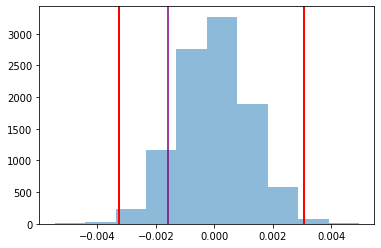

In [30]:
# Plot p_diffs as a histogram
plt.hist(p_diffs, alpha=.5)
# Vertical, purple line for actual difference
plt.axvline(x=diffs, color = 'purple')
# Lines for p_diffs
plt.axvline(x=np.percentile(p_diffs, .5), color='red', linewidth=2);
plt.axvline(x=np.percentile(p_diffs, 99.5), color='red', linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in `ab_data.csv`?

In [31]:
(p_diffs > diffs).mean()

0.9038

k. The value calculated above is called the p-value. There is weak evidence against the null so we fail to reject the hypothesis. This p-value is not statistically signficant with a 95% confidence interval. Therefore, new pages are not better than the old pages and the old pages should be kept.

l. Then, I calculate the number of conversions for each page, as well as the number of individuals who received each page.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_new = df2.query('landing_page == "new_page"')['converted'].count()

m. I now use **stats.proportions_ztest** to compute the t-statistic and p-value.

In [33]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

(1.3109241984234394, 0.9050583127590245)

n. **stats.proportions_ztest** calculates that the t-statistic is 1.31 and this provides a p-value of 0.905. Because 0.905 is not smaller than the 0.05 significance level, the results are not significant. Thus, we fail to reject the hypothesis again. They agree with the findings found in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

<font color='deepskyblue'>**1.**</font> In this final part, I will show that the results in A/B testing can be acheived through regression.<br><br>

a. Since each row is either a conversion or no conversion, I will be performing a logistic regression.

b. I use **statsmodels** to fit the logistic regression model. This allows me to see if there is a significant difference in conversion based on whether a customer receives a new or old page. I first need to create a column for the `intercept`, and create a dummy variable column named `ab_page`. `ab_page` equals 1 when an individual receives `treatment` and 0 if they receive `control`.

In [34]:
df2['intercept'] = 1
df2[['ab_page','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [35]:
y = df2['converted']
x = df2[['intercept','ab_page']]
log_mod = sm.Logit(y, x)
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Below is a summary of my model.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:20:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [37]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [38]:
1/_

intercept    7.306593
ab_page      1.015102
dtype: float64

e. The p-value for `ab_page` is 0.190. This is still larger than 0.05 and is therefore still not statistically significant. It does not match the value calculated with **stats.proportions_ztest** in Part II as the p-value results in the logistic regression are two-tailed. While the one in Part II is one-tailed. 
    
The results suggest that on the new pages, conversion is 0.98x more likely than non-conversion.

f. As we failed to reject $H_1$, it would be beneficial to look at converted relationship with other variables.
However, you have to be careful when adding additional terms in a regression model as if you add irrelevant ones it can adversely affect the regression. The regression can also be negatively affected if the added variables are highly correlated. 

g. 
I am going to read in the `countries.csv` dataset and create a new df to merge together the datasets on the approporiate rows. I want to find out if country has an impact on conversion rates. I am going to create dummy variables for this new `country` column and recalculate the logistic regression.

In [39]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. I would also like to look at an interaction between page and country to see if there are significant effects on conversion.

In [41]:
df_new['page_CA'] = df_new['ab_page']*df_new['CA']
df_new['page_UK'] = df_new['ab_page']*df_new['UK']
df_new['page_US'] = df_new['ab_page']*df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_CA,page_UK,page_US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [42]:
df_new['intercept'] = 1

In [43]:
y = df_new['converted']
x1 = df_new[['intercept', 'ab_page', 'UK', 'US', 'page_UK','page_US']]
x2 = df_new[['intercept', 'ab_page', 'UK', 'US']]
log_mod1 = sm.Logit(y, x1)
log_mod2 = sm.Logit(y, x2)
results1 = log_mod1.fit()
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


> This logistic regression model shows page group and country effects on conversion.

In [44]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:20:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [45]:
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [46]:
1/_

intercept    7.614303
ab_page      1.015056
UK           0.950621
US           0.960062
dtype: float64

- If the user is based in Canada, they are 0.95x more likely to convert than if they were based in UK, holding all other variables constant.
- If the user is based in Canada, they are 0.96x more likely to convert than if they were based in US, holding all other variables constant.
- None of the variables are statisically significant. The UK variable would be significant at 10% confidence level but this is quite low confidence interval and means we have less certainty in them. This low significance would suggest that the UK are more receptive to pages compared to Canada. Canada may be experiencing some change aversion.

> This logistic regression model shows page group and country effects on conversion. I have also added interaction terms for ab_page and country to this analysis.

In [47]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 25 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        23:20:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [48]:
np.exp(results1.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
US           1.017682
page_UK      1.081428
page_US      1.048001
dtype: float64

In [49]:
1/_

intercept    7.418713
ab_page      1.069775
UK           0.988285
US           0.982625
page_UK      0.924703
page_US      0.954198
dtype: float64

- None of the variables are statistically significant. Therefore, there is weak evidence against the null hypothesis and we fail to reject it.
- If the user is based in Canada, they are approximately 0.98x more likely to convert than if they were based in UK or US, holding all other variables constant.
- If the page is new and the user is in UK they are 1.08x more likely to convert than if it was a Canadian seeing a new page.
- If the page is new and the user is in US they are 1.05x more likely to convert than if it was a Canadian seeing a new page.
- This again follows the pattern above that UK users are more receptive to change.

<a id='conclusions'></a>
## Conclusions
### Part I - Probability
- The original dataset is made up of 294478 rows and 290584 unique users.
- 3893 rows had incorrect information and were dropped.
- 1 row was duplicated row and was also dropped.
- The probability of the user being given a new page is approximately 50%, making the experiment fair.
- 11.96% of the dataset converted. 12.04% of the control group converted. 11.88% of the treatment group converted.

### Part II - A/B Test
- The p-value calculated from the simulation (0.9038) suggests there is weak evidence against the null so we fail to reject the hypothesis.
- The **stats.proportions_ztest** calculates that the t-statistic is 1.31 and this provides a p-value of 0.905. Supporting the findings of the simulation.

### Part III - Regression
- In the first logistic regression, we found that the page group's p-value is 0.190. This value is still not statistically significant. This indicates that the treament/new landing page were not better than the control/old pages.
- The second logistic regression found that between UK, USA and Canada, country did not have much of an effect on conversion. There was a little evidence that Canada and UK were slightly significant at a 10% significance level. However, the relationship is very weak and may be due to other factors such as change aversion. Overall, the odds ratios do not differ much and mean that users may not be more likely to convert depending on their location.
- The last logistic regression made use of interaction terms. Results were similar to past regressions, in that the null hypothesis is rejected, due to values being larger than the significance level.
- There is overwhelming evidence that the new page is not better than the old page. Therefore, the old pages should be kept for now. Different changes can be made to the landing page so that further A/B testing can take place.